# ARIMA LTSF Baseline

#### Setup

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from hydra import initialize, compose
from darts import TimeSeries
from pandas import DataFrame

from darts.models.forecasting.sf_auto_arima import StatsForecastAutoARIMA
from utilsforecast.evaluation import evaluate


In [2]:
import warnings
warnings.filterwarnings('ignore')

Load an arbitrary config to load the datamodule

In [3]:
initialize(
    version_base=None,
    config_path="../configs",
)
cfg = compose(
    config_name="lightgbm-uni.yaml",
)

Resolve Hydra Config

In [4]:
os.chdir('..')

from src import pipelines

datamodule, _ = pipelines.resolve_config(cfg)

get dataset from datamodule. 

In [5]:
Y_df = datamodule.pipeline()


In [6]:
Y_df.head(3)

,Unnamed: 0,ds,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,ward_C_planned_absences,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,0,2022-01-01 12:00:00,9,50,5,12,38,5,7,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,1.224647e-16,-1.000000,ward_A_nursing_staff_capacity
1,1,2022-01-01 13:00:00,14,50,8,20,38,6,12,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-2.588190e-01,-0.965926,ward_A_nursing_staff_capacity
2,2,2022-01-01 14:00:00,14,50,8,20,38,6,12,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-5.000000e-01,-0.866025,ward_A_nursing_staff_capacity


configure evaluation

get callables from metric names

In [7]:
from src.evaluation import get_metric
eval_cfg = cfg.evaluation
metrics = {k: get_metric(k) for k in eval_cfg.metrics}
print(metrics)

{'mae': <function mae at 0x7fa7e514c820>, 'rmse': <function rmse at 0x7fa7e514c940>, 'smape': <function smape at 0x7fa7e514caf0>}


Instantiate the ARIMA model

season_length = 24 corresponds to hourly time series data

In [8]:
model = StatsForecastAutoARIMA(season_length=24)


The following functions generates darts TimeSeries from the data

In [9]:

def darts_series_from_df(
    train_set: DataFrame,
    val_set: DataFrame,
    hist_exog_list: list[str] | None,
    futr_exog_list: list[str] | None,
    freq: str,
) -> tuple[tuple[TimeSeries, TimeSeries | None, TimeSeries | None], ...]:
    """
Create TimeSeries objects from a pandas DataFrame for use in Darts.

Args:
- train_set: The input DataFrame containing the time series training data.
- val_set: The input DataFrame containing the time series validation data.
- hist_exog_list: A list of column names in the DataFrame that contain historical exogenous variables.
- futr_exog_list: A list of column names in the DataFrame that contain future exogenous variables.
- freq: The frequency of the time series data (e.g. 'D' for daily, 'M' for monthly, etc.).

Returns:
- Two tuples of three TimeSeries objects:
    1.1 series: a TimeSeries object from train_set
    1.2 past covariates: a TimeSeries object containing the training data past covariates
    1.3 future_covariates: a TimeSeries object containing the training data future covariates
    2.1 val_series: a TimeSeries object from the validation set
    2.2 val_past_covariates: a TimeSeries object containing the validation data past covariates
    2.3 val_future_covariates: a TimeSeries object containing the validation data future covariates
"""
    series = TimeSeries.from_dataframe(train_set, time_col="ds", value_cols="y", freq=freq)
    val_series = TimeSeries.from_dataframe(val_set, time_col="ds", value_cols="y", freq=freq)
    if hist_exog_list:
        past_covariates = TimeSeries.from_dataframe(
            train_set,
            time_col="ds",
            value_cols=hist_exog_list,
            freq=freq,
        )
        val_past_covariates = TimeSeries.from_dataframe(
            val_set, time_col="ds", value_cols=hist_exog_list, freq=freq
        )
    else:
        past_covariates = None
        val_past_covariates = None
    if futr_exog_list:
        future_covariates = TimeSeries.from_dataframe(
            train_set,
            time_col="ds",
            value_cols=futr_exog_list,
            freq=freq,
        )
        val_future_covariates = TimeSeries.from_dataframe(
            val_set, time_col="ds", value_cols=futr_exog_list, freq=freq
        )
    else:
        future_covariates = None
        val_future_covariates = None
    return (
        (series, past_covariates, future_covariates),
        (val_series, val_past_covariates, val_future_covariates),
    )


Train test split

In [10]:
from src.data import utils

kwargs = {}
val_start_date = "2023-02-01" # HPO
test_start_date = "2023-04-01" # eval
df_train, df_test = utils.split_train_test(Y_df, test_start_date)
test_start_date = df_test.iloc[0]["ds"]
kwargs["test_start"] = test_start_date
print(f"train+val split shape: {df_train.shape}")
print(f"test split start: {test_start_date}")
print(
    f"test split shape: {df_test.shape}, which is {len(df_test) / len(Y_df):.1%} of the total dataset."
)


debug: received test split start fixed date: 2023-04-01 00:00:00
train+val split shape: (10908, 51)
test split start: 2023-04-01 00:00:00
test split shape: (2161, 51), which is 16.5% of the total dataset.


In [11]:
df_train = df_train.drop(columns="unique_id").set_index("ds")

We additionally standardize the data

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas")
scaled_df = scaler.fit_transform(df_train)
scaled_df = scaled_df.reset_index()
scaled_df.head()

,ds,Unnamed: 0,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,ward_C_planned_absences,...,sin_day_of_week,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day
0,2022-01-01 12:00:00,-1.731892,-0.333653,-0.245958,-1.693329,0.242796,-1.339421,-1.532499,-0.164284,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,0.000985,-1.414084
1,2022-01-01 13:00:00,-1.731574,0.432459,-0.245958,-0.747481,1.567420,-1.339421,-1.190186,0.859840,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.365041,-1.365896
2,2022-01-01 14:00:00,-1.731257,0.432459,-0.245958,-0.747481,1.567420,-1.339421,-1.190186,0.859840,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.706122,-1.224615
3,2022-01-01 15:00:00,-1.730939,-0.946543,-0.245958,-0.747481,-0.088360,-1.339421,-1.190186,-0.573934,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.999016,-0.999870
4,2022-01-01 16:00:00,-1.730622,-0.946543,-0.245958,-0.747481,-0.253938,-1.339421,-1.190186,-0.573934,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-1.223761,-0.706977


We also standardize the complete dataset as we will need it later

In [13]:
Y_df_ = Y_df.drop(columns="unique_id").set_index("ds")
Y_df_scaled = scaler.transform(Y_df_)
Y_df_scaled = Y_df_scaled.reset_index()
Y_df_scaled.head()

,ds,Unnamed: 0,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,ward_C_planned_absences,...,sin_day_of_week,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day
0,2022-01-01 12:00:00,-1.731892,-0.333653,-0.245958,-1.693329,0.242796,-1.339421,-1.532499,-0.164284,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,0.000985,-1.414084
1,2022-01-01 13:00:00,-1.731574,0.432459,-0.245958,-0.747481,1.567420,-1.339421,-1.190186,0.859840,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.365041,-1.365896
2,2022-01-01 14:00:00,-1.731257,0.432459,-0.245958,-0.747481,1.567420,-1.339421,-1.190186,0.859840,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.706122,-1.224615
3,2022-01-01 15:00:00,-1.730939,-0.946543,-0.245958,-0.747481,-0.088360,-1.339421,-1.190186,-0.573934,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-0.999016,-0.999870
4,2022-01-01 16:00:00,-1.730622,-0.946543,-0.245958,-0.747481,-0.253938,-1.339421,-1.190186,-0.573934,0.811318,...,1.001101,-0.314882,-0.156515,1.256708,0.27834,1.433354,0.489788,1.146908,-1.223761,-0.706977


Retrieve the validation data and transform the data to TimeSeries objects

In [14]:
val_set = scaled_df[scaled_df.ds >= val_start_date]
train_set = scaled_df[scaled_df.ds < val_start_date]
val_set_size = len(val_set)
print(
    f"val split size: {val_set_size}, which starts from date {val_start_date} and is {val_set_size / len(scaled_df):.1%} of the train split or {val_set_size / len(Y_df):.1%} of the total dataset."
)

(
    (series, past_covariates, future_covariates),
    (val_series, val_past_covariates, val_future_covariates),
) = darts_series_from_df(
    train_set,
    val_set,
    cfg.model.get("hist_exog_list", None),
    cfg.model.get("futr_exog_list", None),
    cfg.dataset.freq,
)
series

val split size: 1416, which starts from date 2023-02-01 and is 13.0% of the train split or 10.8% of the total dataset.


<TimeSeries (DataArray) (ds: 9492, component: 1, sample: 1)> Size: 76kB
array([[[-0.33365339]],

       [[ 0.4324585 ]],

       [[ 0.4324585 ]],

       ...,

       [[ 0.58568088]],

       [[-0.94654289]],

       [[-0.94654289]]])
Coordinates:
  * ds         (ds) datetime64[ns] 76kB 2022-01-01T12:00:00 ... 2023-01-31T23...
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [15]:
model.fit(
    series=series,
)

StatsForecastAutoARIMA(add_encoders=None, season_length=24)

Generate a 3 months forecast using the standardized data

Create a TimeSeries object from the complete time series data as we need it as input for the historical_forecast function

In [16]:
(
    (eval_series, eval_past_covariates, eval_future_covariates),
    _,
) = darts_series_from_df(
    Y_df_scaled,
    val_set,
    cfg.model.get("hist_exog_list", None),
    cfg.model.get("futr_exog_list", None),
    cfg.dataset.freq,
)
l_timeseries = model.historical_forecasts(
    series=eval_series,
    past_covariates=eval_past_covariates,
    future_covariates=eval_future_covariates,
    start=test_start_date,
    forecast_horizon=cfg.evaluation.horizon,
    stride=cfg.evaluation.horizon,
    last_points_only=False,
    verbose=True,
    show_warnings=True,
    retrain=True,
    train_length=cfg.evaluation.lookback,
)
if isinstance(l_timeseries, list):
    ts_df_scaled = pd.concat([t.pd_dataframe() for t in l_timeseries])
else:
    ts_df_scaled = l_timeseries.pd_dataframe()
print("historical_forecasts output:")
# inverse transform
ts_df_scaled

  0%|          | 0/3 [00:00<?, ?it/s]

historical_forecasts output:


component,y
ds,
2023-04-01 00:00:00,-0.946542
2023-04-01 01:00:00,-0.946542
2023-04-01 02:00:00,-0.946542
2023-04-01 03:00:00,-0.946543
2023-04-01 04:00:00,-0.946543
...,...
2023-06-29 19:00:00,-0.333653
2023-06-29 20:00:00,0.279236
2023-06-29 21:00:00,0.279236


In [17]:
def inv_transform(scaler, data: pd.DataFrame, col_name: str):
    """
Inverse transfroms a column of a scaled dataset
Args:
- scaler: The scaler that was used to standardize the data.
- data: The time series data containing the column to be inverse transformed.
- col_name: The column to be inverse transformed.


Returns:
- The inverse transformed time series data

    """
    dummy = pd.DataFrame(np.zeros((len(data), len(scaler.feature_names_in_))), columns=scaler.feature_names_in_, index=data.index)
    dummy[col_name] = data.values
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=scaler.feature_names_in_, index=data.index)
    return dummy[[col_name]]

Inverse transform the forecast

In [18]:
ts_df_inv = inv_transform(scaler, ts_df_scaled["y"], col_name="y")
ts_df_inv

,y
ds,
2023-04-01 00:00:00,5.000007
2023-04-01 01:00:00,5.000006
2023-04-01 02:00:00,5.000003
2023-04-01 03:00:00,5.000000
2023-04-01 04:00:00,4.999997
...,...
2023-06-29 19:00:00,9.000000
2023-06-29 20:00:00,13.000000
2023-06-29 21:00:00,13.000000


In [19]:
ts_df_inv = ts_df_inv.reset_index()
ts_df_inv = ts_df_inv.rename(columns={"y": "AutoARIMA"})
ts_df_inv = ts_df_inv.merge(df_test, how='left', on="ds")
ts_df_inv.head()

,ds,AutoARIMA,Unnamed: 0,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2023-04-01 00:00:00,5.000007,10908,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.000000,1.000000,ward_A_nursing_staff_capacity
1,2023-04-01 01:00:00,5.000006,10909,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.258819,0.965926,ward_A_nursing_staff_capacity
2,2023-04-01 02:00:00,5.000003,10910,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.500000,0.866025,ward_A_nursing_staff_capacity
3,2023-04-01 03:00:00,5.000000,10911,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.707107,0.707107,ward_A_nursing_staff_capacity
4,2023-04-01 04:00:00,4.999997,10912,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.866025,0.500000,ward_A_nursing_staff_capacity


<Axes: >

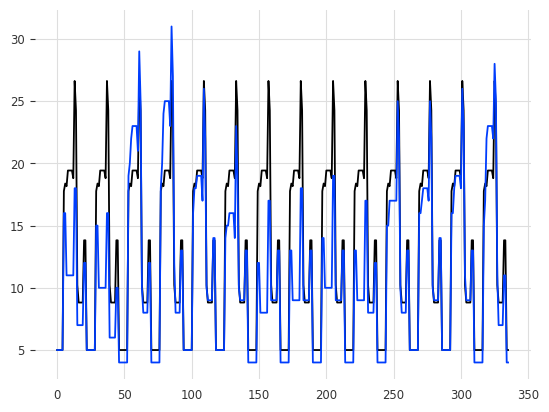

In [20]:
ts_df_inv["AutoARIMA"][0:336].plot()
ts_df_inv["y"][0:336].plot()

In [21]:
evaluate(ts_df_inv, metrics=list(metrics.values()), models=["AutoARIMA"])

,unique_id,metric,AutoARIMA
0,ward_A_nursing_staff_capacity,mae,2.643270
1,ward_A_nursing_staff_capacity,rmse,4.191600
2,ward_A_nursing_staff_capacity,smape,0.105658
